# Imports

In [1]:
import os, torch, random
import SimpleITK
import numpy as np
import matplotlib.pyplot as plt 
from torchvision import transforms
from torch.utils.data import DataLoader
import re
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

C:\Users\mi3se\AppData\Roaming\Python\Python310\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: Could not find module 'C:\Users\mi3se\AppData\Roaming\Python\Python310\site-packages\torchvision\image.pyd' (or one of its dependencies). Try using the full path with constructor syntax.
  warn(f"Failed to load image Python extension: {e}")


In [2]:
SEED = 2024

def seed_everything(seed):
    random.seed(seed)
    torch.manual_seed(seed)
    np.random.seed(seed)

seed_everything(SEED)

## GPU

In [3]:
# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


# Dataset

In [4]:
data_transforms = {
    'train': transforms.Compose([
        # Converts a PIL Image or numpy.ndarray (H x W x C) in the range [0, 255] 
        # to a torch.FloatTensor of shape (C x H x W) in the range [0.0, 1.0]
        transforms.ToTensor(), 
        # transforms.RandomResizedCrop(224),
        # transforms.RandomHorizontalFlip(),
    ]),
    'test': transforms.Compose([
        transforms.ToTensor(), # PIL Image or numpy.ndarray (H x W x C)
        # transforms.Resize(256),
        # transforms.CenterCrop(224)
    ]),
}

In [5]:
from OASIS_2D.dataset import OASIS_Dataset

train_dataset = OASIS_Dataset(train=True, seed=SEED)
test_dataset = OASIS_Dataset(train=False, seed=SEED)

batch_size = 8
train_dataloader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True
)

test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

Total 77, disease 37, healthy 40.             Unique patients 42.
Total 23, disease 13, healthy 10.             Unique patients 11.


# Model

In [6]:
from torchvision import models

# https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html
model = models.resnet18(weights='DEFAULT')

# Here, we need to freeze all the network except the final layer. 
# We need to set requires_grad = False to freeze the parameters 
# so that the gradients are not computed in backward().
for param in model.parameters():
    param.requires_grad = False

In [7]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [8]:
# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to ``nn.Linear(num_ftrs, len(class_names))``.
model.fc = torch.nn.Linear(num_ftrs, 2)

model = model.to(device)

# Train

In [9]:
from OASIS_2D.oasis import Experiment

result_dir = os.path.join('OASIS_2D', 'scratch', model._get_name())
# result_dir = os.path.join('OASIS_2D', 'results', 'ResNet18')
exp = Experiment(result_dir=result_dir, device=device)

train_history = exp.train(
    model, train_dataloader=train_dataloader, 
    val_dataloader=test_dataloader,
    epochs=25, learning_rate=1e-3
)

Epoch 1/25
----------


Train loss: 7.2846 Acc: 0.5584
Val loss: 1.9829 Acc: 0.6957
Validation loss decreased (inf --> 1.982876).  Saving model ...

Epoch 2/25
----------
Train loss: 6.2798 Acc: 0.6104
Val loss: 1.8889 Acc: 0.4783
Validation loss decreased (1.982876 --> 1.888869).  Saving model ...

Epoch 3/25
----------
Train loss: 6.4414 Acc: 0.5714
Val loss: 1.6147 Acc: 0.7826
Validation loss decreased (1.888869 --> 1.614666).  Saving model ...

Epoch 4/25
----------
Train loss: 5.2994 Acc: 0.6883
Val loss: 1.5953 Acc: 0.7391
Validation loss decreased (1.614666 --> 1.595265).  Saving model ...

Epoch 5/25
----------
Train loss: 5.1860 Acc: 0.7662
Val loss: 1.2093 Acc: 0.9130
Validation loss decreased (1.595265 --> 1.209294).  Saving model ...

Epoch 6/25
----------
Train loss: 4.1221 Acc: 0.8831
Val loss: 1.2843 Acc: 0.7826
EarlyStopping counter: 1 out of 10

Epoch 7/25
----------
Train loss: 4.2544 Acc: 0.8571
Val loss: 1.2450 Acc: 0.9565
EarlyStopping counter: 2 out of 10

Epoch 8/25
----------
Train los

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

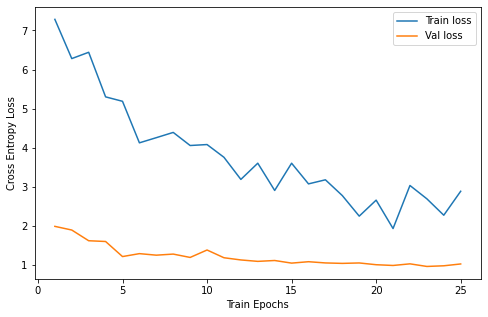

In [16]:
plt.figure(figsize=(8, 5))
plt.plot(train_history['epoch'], train_history['train_loss'], label='Train loss')
plt.plot(train_history['epoch'], train_history['val_loss'], label='Val loss')
plt.xlabel('Train Epochs')
plt.ylabel('Cross Entropy Loss')
plt.legend()
plt.savefig(os.path.join(result_dir, 'train_history.jpg'), dpi=200)
plt.show()

# Test

In [12]:
print('Evaluating train data')
train_result = exp.test(model, train_dataloader)

print('Evaluating test data')
test_result = exp.test(model, test_dataloader)

Loss: 1.5833, Accuracy 1.0000, F1 1.0000, AUC 1.0000.
Loss: 0.9562, Accuracy 0.9565, F1 0.9630, AUC 0.9615.


In [13]:
import json

with open(os.path.join(result_dir, 'train.json'), 'w') as output_file:
    json.dump(train_result, output_file, indent=4)

In [14]:
with open(os.path.join(result_dir, 'test.json'), 'w') as output_file:
    json.dump(test_result, output_file, indent=4)